In [1]:
# Inicializacoes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as datetime
import plotly.express as px
import time
import tensorflow as tf
import math
from tensorflow import keras
from tensorflow.keras import layers, activations
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from sklearn import preprocessing
from joblib import dump, load

np.random.seed(7)

url_dataset='https://github.com/rafasilveira/ibovespa-stocks-prediction/blob/master/data/b3_stocks_1994_2020.csv?raw=true'
ticker='PETR4'

In [2]:
# carga de dados para uma acao

brute = pd.read_csv(url_dataset)
data = brute[brute["ticker"] == ticker]
# data['dt'] = pd.to_datetime(data.datetime.values)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5640 entries, 209606 to 1881973
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  5640 non-null   object 
 1   ticker    5640 non-null   object 
 2   open      5640 non-null   float64
 3   close     5640 non-null   float64
 4   high      5640 non-null   float64
 5   low       5640 non-null   float64
 6   volume    5640 non-null   float64
dtypes: float64(5), object(2)
memory usage: 352.5+ KB


In [3]:
data.head(3)

,datetime,ticker,open,close,high,low,volume
209606,1998-03-16,PETR4,276.0,275.0,276.0,273.99,27078933.9
209805,1998-03-17,PETR4,275.0,277.0,278.0,274.50,41049029.3
210027,1998-03-18,PETR4,277.0,275.5,279.0,275.00,40506405.9


Text(0.5, 1.0, 'Fechamento para PETR4')

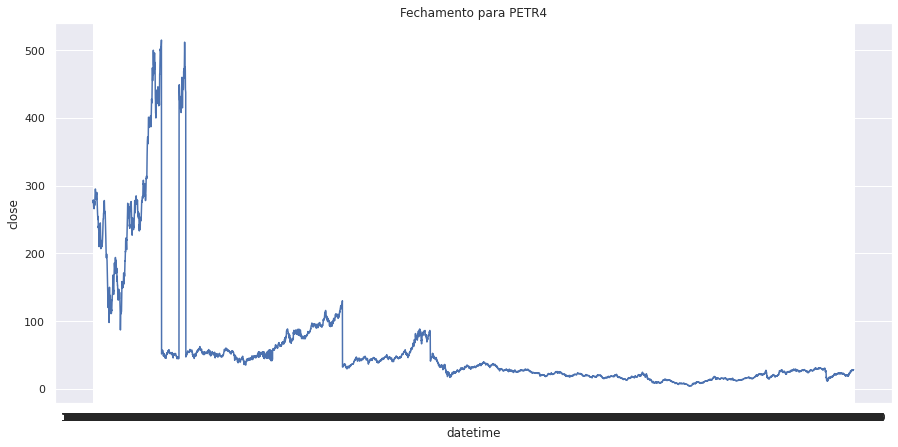

In [4]:
# grafico
df_work = data.copy()
df_work.drop(columns=['ticker'],inplace=True)

plt.figure(figsize=(15,7))
sns.set()
sns.lineplot(x = df_work.datetime, y = 'close',data=df_work).set_title(f'Fechamento para {ticker}')

In [5]:
# treino e teste
X = df_work[['open', 'close', 'high', 'low', 'volume']]
Y = df_work[['close']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle = False)

# normalizacao
x_transformer = preprocessing.MinMaxScaler((-1,1)).fit(X)
x_train_transformed = x_transformer.transform(X_train)
x_test_transformed = preprocessing.MinMaxScaler((-1,1)).fit(X).transform(X_test)

y_transformer = preprocessing.MinMaxScaler((-1,1)).fit(Y)
y_train_transformed = y_transformer.transform(Y_train)
y_test_transformed = preprocessing.MinMaxScaler((-1,1)).fit(Y).transform(Y_test)

In [6]:
# formas
print("Shapes")
print(f"X \ttrain {X_train.shape[0]}, {X_train.shape[1]} \ttest {X_test.shape[0]}, {X_test.shape[1]}")
print(f"Y \ttrain {Y_train.shape[0]}, {Y_train.shape[1]} \ttest {Y_test.shape[0]}, {Y_test.shape[1]}")

print("")

print("Cost \tmin \tmax")
print(f"Train \t{X_train.close.min()}\t{X_train.close.max()}")
print(f"Test \t{X_test.close.min()}\t{X_test.close.max()}")

print("")

print("Volume \tmin \t\tmax")
print(f"Train \t{X_train.volume.min()}\t{X_train.volume.max()}")
print(f"Test \t{X_test.volume.min()}\t{X_test.volume.max()}")

Shapes
X 	train 4512, 5 	test 1128, 5
Y 	train 4512, 1 	test 1128, 1

Cost 	min 	max
Train 	4.2	515.0
Test 	8.3	30.97

Volume 	min 		max
Train 	1612032.8	3364836904.0
Test 	82501537.0	5972965972.0


In [7]:
# Criacao do dataset por serie temporal
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10

# reshape para [samples, time_steps, n_features]
X_train_f, y_train_f = create_dataset(x_train_transformed, y_train_transformed, time_steps)
X_test_f, y_test_f = create_dataset(x_test_transformed, y_test_transformed, time_steps)

print("Shapes dataset serie temporal")
print(X_train_f.shape, y_train_f.shape)
print(X_test_f.shape, y_test_f.shape)

Shapes dataset serie temporal
(4502, 10, 5) (4502, 1)
(1118, 10, 5) (1118, 1)


In [8]:
# Criacao dos modelos
# todo: implementar grid search

# n camadas: 1 - 3
# n unidades: 32, 64, 128
# tamanho sequencia entrada: 11, 22, 44
# dropout: 0, 0.5, 0.7

model = keras.Sequential()
model.add(keras.layers.Input(shape=((X_train_f.shape[1], X_train_f.shape[2]))))
model.add(layers.LSTM(100, activation = 'tanh', dropout=0))
model.add(layers.Flatten())
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42400     
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
406/406 [==============================] - 6s 9ms/step - loss: 0.0140 - val_loss: 6.2853e-05
Epoch 2/100
406/406 [==============================] - 3s 7ms/step - loss: 0.0044 - val_loss: 1.2243e-05
Epoch 3/100
406/406 [==============================] - 3s 7ms/step - loss: 0.0039 - val_loss: 7.4763e-06
Epoch 4/100
406/406 [==============================] - 3s 7ms/step - loss: 0.0032 - val_loss: 6.3866e-06
Epoch 5/100
406/406 [==============================] - 3s 8ms/step - loss: 0.0029 - val_loss: 6.7254e-06
Epoch 6/100
406/406 [==============================] - 3s 7ms/step - loss: 0.0028 - val_loss: 6.9013e-06
Epoch 7/100
406/406 [==============================] - 3s 7ms/step - loss: 0.0027 - val_loss: 7.2511e-06
Epoch 8/100
406/406 [==============================] - 3s 8ms/step - loss: 0.0027 - val_loss: 6.3622e-06
Epoch 9/100
406/406 [==============================] - 3s 8ms/step - loss: 0.0028 - val_loss: 8.9994e-06
Epoch 10/100
406/406 [==============================] -

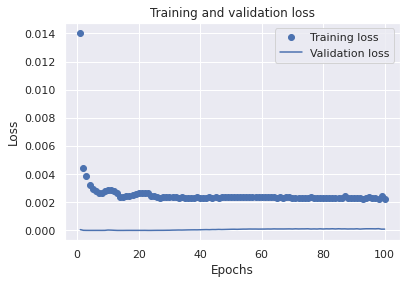

In [9]:
# hist = grid.best_estimator_.fit(X_train_f, y_train_f, batch_size = 40, epochs = 80, shuffle=False, validation_split=0.1)

# fitting
hist = model.fit(X_train_f, y_train_f, batch_size = 10, epochs = 100, shuffle=False, validation_split=0.1)
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Predicao
y_pred = model.predict(X_test_f)
# y_pred = grid.best_estimator_.predict(X_test_f)


y_test_inv = y_transformer.inverse_transform(y_test_f)
y_pred_inv = y_transformer.inverse_transform(y_pred)
combined_array = np.concatenate((y_test_inv,y_pred_inv),axis=1)


df_final = pd.DataFrame(data = combined_array, columns=["actual", "predicted"])

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mse)
print(f"Test score - MSE: {mse}, RMSE: {rmse}")

Test score - MSE: 2.956324508548093, RMSE: 1.7193965536048084


In [11]:
# preparar dados para plotagem
a = np.repeat(1, len(y_test_inv))
# a = np.repeat(1, len(Y_test))
b = np.repeat(2, len(y_pred_inv))

df1 = pd.DataFrame(data = np.concatenate((y_test_inv,(np.reshape(a, (-1, 1)))),axis=1), columns=["price","type"])
# df1 = pd.DataFrame(data = np.concatenate((Y_test,(np.reshape(a, (-1, 1)))),axis=1), columns=["price","type"])
df2 = pd.DataFrame(data = np.concatenate((y_pred_inv,(np.reshape(b, (-1, 1)))),axis=1), columns=["price","type"])

frames = [df1, df2]
result = pd.concat(frames, ignore_index=False)

result["type"].replace({1: "actual", 2: "predict"}, inplace=True)
(result[result.type == "actual"]).head(10)

,price,type
0,8.78,actual
1,9.20,actual
2,9.50,actual
3,9.42,actual
4,9.82,actual
5,9.87,actual
6,9.29,actual
7,9.50,actual
8,9.56,actual
9,9.84,actual


In [15]:
fig = px.line(result, x=result.index.values, y="price", color='type')
fig.show()